In [211]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
from kerastuner import HyperModel

NUMERIC_FEATURES = [
    'p1_height',
    'p2_height',
    'p1_age',
    'p2_age',
    'p1_rating',
    'p2_rating',
    'p1_dev',
    'p2_dev',
    'p1_surface_rating',
    'p2_surface_rating',
    'p1_surface_dev',
    'p2_surface_dev',
    'p1_w',
    'p2_w',
    'p1_l',
    'p2_l',
    'p1_surface_w',
    'p2_surface_w',
    'p1_surface_l',
    'p2_surface_l',
    'p1_inactive_days',
    'p2_inactive_days',
    'p1_recent_rating',
    'p2_recent_rating'
]
CATEGORICAL_FEATURES = [
    'is_hard',
    'is_clay',
    'is_grass',
    'is_bo5',
    'p1_lefty',
    'p2_lefty',
    'p1_home',
    'p2_home'
    
]

dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
validation = pd.read_csv('../data/matches.csv')[76425:]


def build_model(preprocessing_head, inputs, hidden_layer, learning_rate, dropout):
  body = tf.keras.Sequential([
    keras.layers.InputLayer(input_shape=(32,)),
    keras.layers.Dense(hidden_layer, activation='relu'),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics='acc')
  return model


In [212]:
class MyHyperModel(HyperModel):
    def __init__(self, preprocessing_head, inputs):
        self.preprocessing_head = preprocessing_head
        self.inputs = inputs
    def build(self, hp):
        body = tf.keras.Sequential([
            keras.layers.InputLayer(input_shape=(32,)),
            keras.layers.Dense(hp.Int('hidden_size', 200, 600), activation='relu'),
            keras.layers.Dropout(hp.Float('dropout', 0.05, 0.5)),
            keras.layers.Dense(1, activation='sigmoid')
        ])

        preprocessed_inputs = self.preprocessing_head(self.inputs)
        result = body(preprocessed_inputs)
        model = tf.keras.Model(self.inputs, result)

        model.compile(
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 0.003, 0.03)),
                      metrics=['acc']
                      )
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", 2000, 6000),
            **kwargs,
        )

In [213]:
def get_model(dataframe, hidden_layer, learning_rate, dropout):
    labels = dataframe.pop('p1_win')
    dataframe.pop('match_hash')
    dataframe.pop('tourney_name')
    dataframe.pop('tourney_date')
    dataframe.pop('p1_name')
    dataframe.pop('p2_name')

    dataframe_features = dataframe.copy()

    inputs = {}

    # match column names with input objects
    for name, column in dataframe_features.items():
        dtype = tf.float32
        inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

    numeric_inputs = {name:input for name,input in inputs.items()
                    if name in NUMERIC_FEATURES}

    # normalize the numeric inputs and gather them in an array
    x = keras.layers.Concatenate()(list(numeric_inputs.values()))
    norm = keras.layers.Normalization()
    norm.adapt(np.array(dataframe[numeric_inputs.keys()]))
    all_numeric_inputs = norm(x)

    preprocessed_inputs = [all_numeric_inputs]

    for name, input in inputs.items():
        if name in NUMERIC_FEATURES:
            continue
        preprocessed_inputs.append(input)

    preprocessed_inputs_cat = keras.layers.Concatenate()(preprocessed_inputs)
    preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

    features_dict = {name: np.array(value) for name, value in dataframe_features.items()}
    f_dict = {name:values for name, values in features_dict.items()}
    preprocessing(f_dict)

    # data_model = MyHyperModel(preprocessing, inputs)
    data_model = build_model(preprocessing, inputs, hidden_layer, learning_rate, dropout)

    return data_model, features_dict, labels

In [214]:
for hidden_layer in range(400, 401, 100):
    for learning_rate in range(10,11,10):
        learning_rate = learning_rate / 1000
        for int_dropout in range(8, 9):
            dropout = int_dropout / 10
            # dataframe = pd.read_csv('../data/matches.csv')[7389:76425]
            # validation = pd.read_csv('../data/matches.csv')[76425:]
            dataframe = pd.read_csv('../data/matches.csv')[7389:43163]
            validation = pd.read_csv('../data/matches.csv')[43163:59482]
            data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
            _, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)

            for trial in range(1):
                data_model.fit(x=features_dict, y=labels, epochs=20000, batch_size=4000, 
                            callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)],
                            validation_data=(val_features_dict, val_labels),
                    )
            data_model.save(f'test{trial}')
            # data_model.save(f'hidden{hidden_layer}lr{learning_rate}dropout{dropout}trial{trial}')



# data_model, features_dict, labels = get_model(dataframe, 0,0,0)
# _, val_features_dict, val_labels = get_model(validation, 0,0,0)
# tuner = kt.BayesianOptimization(data_model, objective='loss', directory='training_weights', max_trials=80)
# tuner.search(x=features_dict, y=labels, epochs=20000, 
#              validation_data=(val_features_dict, val_labels),
#              callbacks=[tf.keras.callbacks.EarlyStopping('loss', patience=15)]
#             )

Epoch 1/20000
9/9 [==============================] - 2s 155ms/step - loss: 0.6604 - acc: 0.6253 - val_loss: 0.6265 - val_acc: 0.6512
Epoch 2/20000
9/9 [==============================] - 1s 108ms/step - loss: 0.6200 - acc: 0.6582 - val_loss: 0.6288 - val_acc: 0.6484
Epoch 3/20000
9/9 [==============================] - 1s 104ms/step - loss: 0.6134 - acc: 0.6662 - val_loss: 0.6209 - val_acc: 0.6514
Epoch 4/20000
9/9 [==============================] - 1s 103ms/step - loss: 0.6113 - acc: 0.6653 - val_loss: 0.6233 - val_acc: 0.6513
Epoch 5/20000
9/9 [==============================] - 1s 107ms/step - loss: 0.6089 - acc: 0.6665 - val_loss: 0.6210 - val_acc: 0.6505
Epoch 6/20000
9/9 [==============================] - 1s 107ms/step - loss: 0.6081 - acc: 0.6674 - val_loss: 0.6208 - val_acc: 0.6510
Epoch 7/20000
9/9 [==============================] - 1s 108ms/step - loss: 0.6088 - acc: 0.6698 - val_loss: 0.6199 - val_acc: 0.6524
Epoch 8/20000
9/9 [==============================] - 1s 111ms/step - 

INFO:tensorflow:Assets written to: test0\assets


INFO:tensorflow:Assets written to: test0\assets


1118/1118 [==============================] - 5s 4ms/step


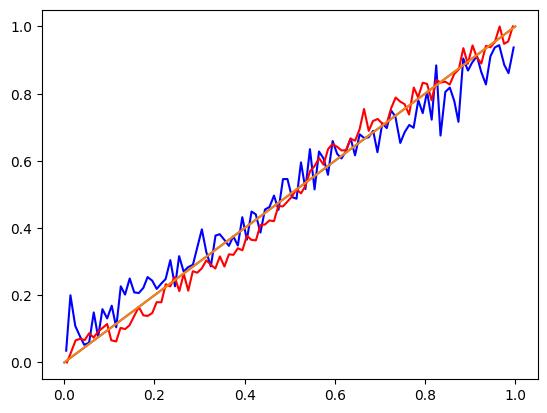

In [215]:
dataframe = pd.read_csv('../data/matches.csv')[7389:43163]
validation = pd.read_csv('../data/matches.csv')[43163:59482]
data_model, features_dict, labels = get_model(dataframe, hidden_layer, learning_rate, dropout)
_, val_features_dict, val_labels = get_model(validation, hidden_layer, learning_rate, dropout)

reloaded = tf.keras.models.load_model('test0')
results = reloaded.evaluate(val_features_dict, val_labels)
results = reloaded.evaluate(features_dict, labels)

val_predictions = reloaded.predict(val_features_dict)
val_labels_list = val_labels.tolist()

predictions = reloaded.predict(features_dict)
labels_list = labels.tolist()

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

x, y = calibration_curve(val_labels_list, val_predictions, n_bins = 100)
plt.plot(y, x, 'b')
plt.plot([0, 1], [0, 1])

x, y = calibration_curve(labels_list, predictions, n_bins = 100)
plt.plot(y, x, 'r')
plt.plot([0, 1], [0, 1])


#_____________________________________________________________
# validation = pd.read_csv('../data/matches.csv')[85000:]
# _, val_features_dict, val_labels = get_model(validation)


# data_model.load_weights('asdf/metrics')
# results = data_model.evaluate(val_features_dict, val_labels)
# predictions = data_model.predict(val_features_dict)
# labels_list = val_labels.tolist()
# print(len(val_features_dict), len(labels_list))
# print(val_features_dict)

# for i in range(0, len(predictions)):
#     print('Prediction:', predictions[i], 'Result:', labels_list[i])

